### 1. Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Generate Synthetic Time Series Data

np.random.seed(42)

dates = [datetime(2020, 1, 1) + timedelta(days=i) for i in range(200)]
trend = np.linspace(0, 10, 200)  # Small upward trend
noise = np.random.randn(200) * 2  # Random noise
values = 50 + trend + np.cumsum(noise)  # Simulated time series


# Create DataFrame

df = pd.DataFrame({'Date': dates, 'Value': values})
df.set_index('Date', inplace=True)

### 2. Plot the Time Series

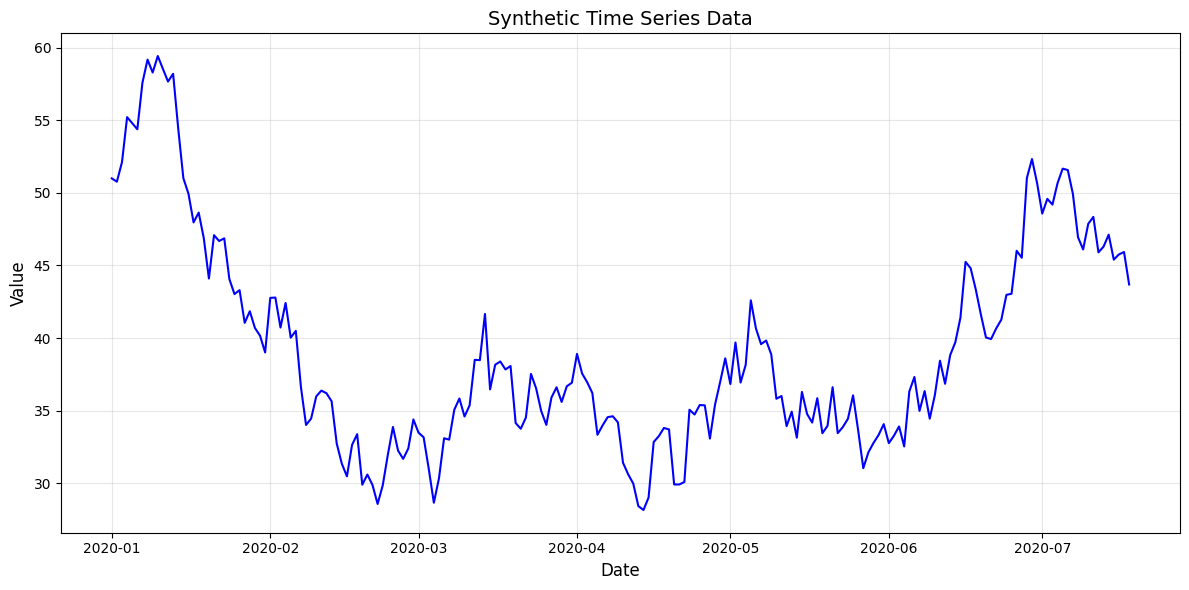

In [2]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Value'], 'b-')
plt.title('Synthetic Time Series Data', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3. Summary Statistics 

In [3]:
# Calculate summary statistics
summary_stats = df['Value'].describe()
print("Summary Statistics:")
print(summary_stats)

# Additional statistics
variance = df['Value'].var()
print(f"\nVariance: {variance:.4f}")

# Range
min_value = df['Value'].min()
max_value = df['Value'].max()
value_range = max_value - min_value
print(f"Range: {value_range:.4f} (Min: {min_value:.4f}, Max: {max_value:.4f})")

Summary Statistics:
count    200.000000
mean      39.166781
std        7.302613
min       28.172240
25%       33.915964
50%       36.658943
75%       43.315119
max       59.413484
Name: Value, dtype: float64

Variance: 53.3282
Range: 31.2412 (Min: 28.1722, Max: 59.4135)


### 4. Check for missing values and handle them if necessary.

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in the dataset:")
print(missing_values)

Missing values in the dataset:
Value    0
dtype: int64


### 5. Calculate rolling statistics to see how they change over time 20 Day Window

These statistics and visualizations will help to understand the central tendency, dispersion, and temporal patterns in the synthetic time series data. The rolling statistics are particularly useful for time series analysis as they show how data characteristics evolve over time.

In [5]:
rolling_window = 20  # 20-day window
rolling_mean = df['Value'].rolling(window=rolling_window).mean()
rolling_std = df['Value'].rolling(window=rolling_window).std()

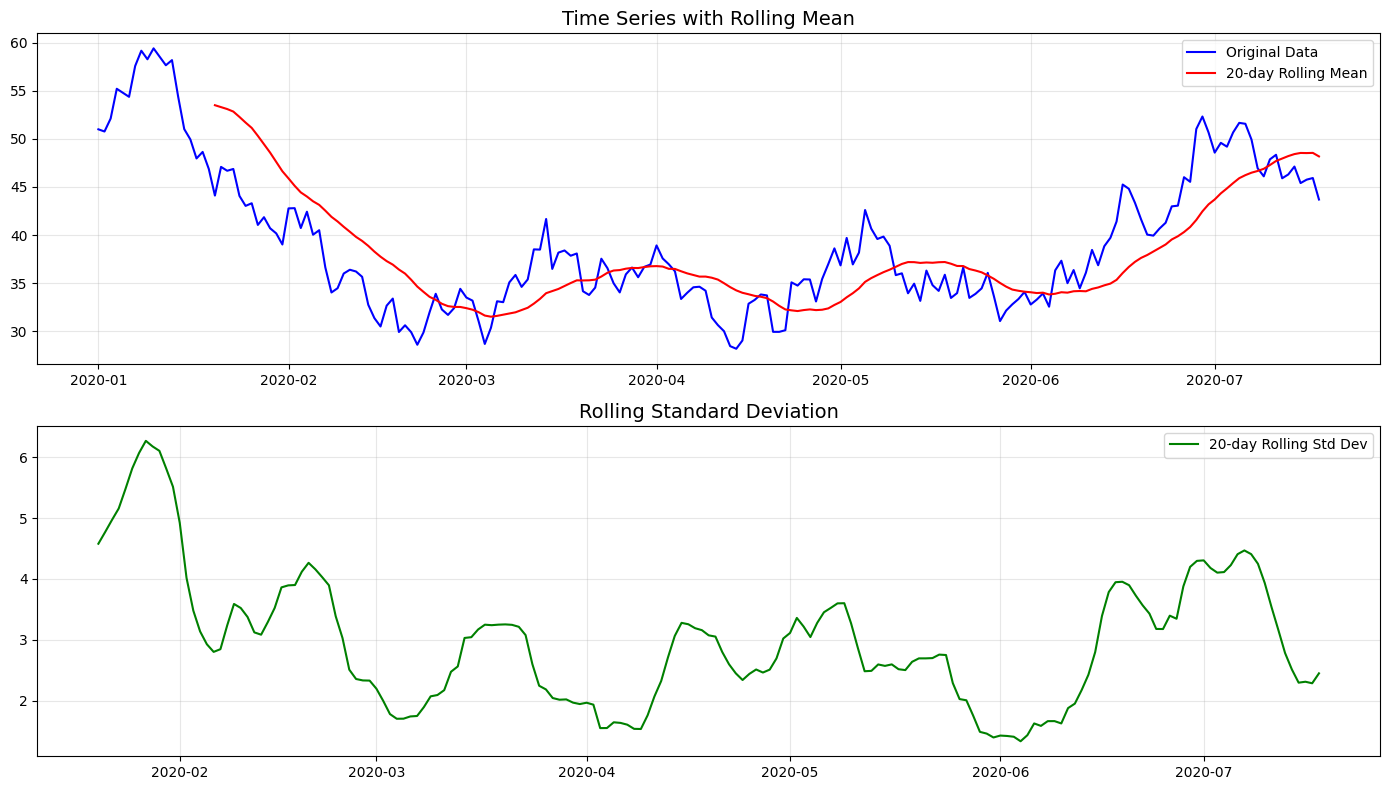

In [6]:
# Plot the time series with rolling statistics
plt.figure(figsize=(14, 8))

# Original data
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Value'], 'b-', label='Original Data')
plt.plot(rolling_mean.index, rolling_mean, 'r-', label=f'{rolling_window}-day Rolling Mean')
plt.title('Time Series with Rolling Mean', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Standard deviation
plt.subplot(2, 1, 2)
plt.plot(rolling_std.index, rolling_std, 'g-', label=f'{rolling_window}-day Rolling Std Dev')
plt.title('Rolling Standard Deviation', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6. Test for Stationarity

In [7]:
# Step 2: Apply the ADF Test
result = adfuller(df['Value'])

# Display the ADF Test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.125356115524277
p-value: 0.23444175340351148
Critical Values:
   1%: -3.4636447617687436
   5%: -2.8761761179270766
   10%: -2.57457158581854


If the p-value from the test is greater than 0.05, the series is not stationary and needs transformation.

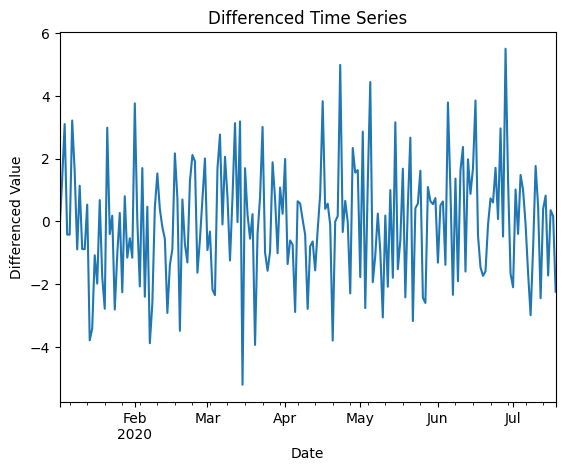

ADF Statistic (Differenced): -14.691774924143184
p-value (Differenced): 3.0415339027295784e-27
Critical Values:
   1%: -3.4638151713286316
   5%: -2.876250632135043
   10%: -2.574611347821651


In [8]:
# Step 3: Apply First-Order Differencing
df_diff = df['Value'].diff().dropna()

# Plot the differenced series
df_diff.plot(title='Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.show()

# Step 4: Reapply the ADF Test
result_diff = adfuller(df_diff)

# Display the ADF Test results
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')



--- Testing Original Series ---
Augmented Dickey-Fuller Test Results for Original Series:
ADF Test Statistic: -2.1254
p-value: 0.2344
# Lags Used: 0
# Observations: 199
Critical Values:
   1%: -3.4636
   5%: -2.8762
   10%: -2.5746

Conclusion: The Original Series is NON-STATIONARY (p-value > 0.05)


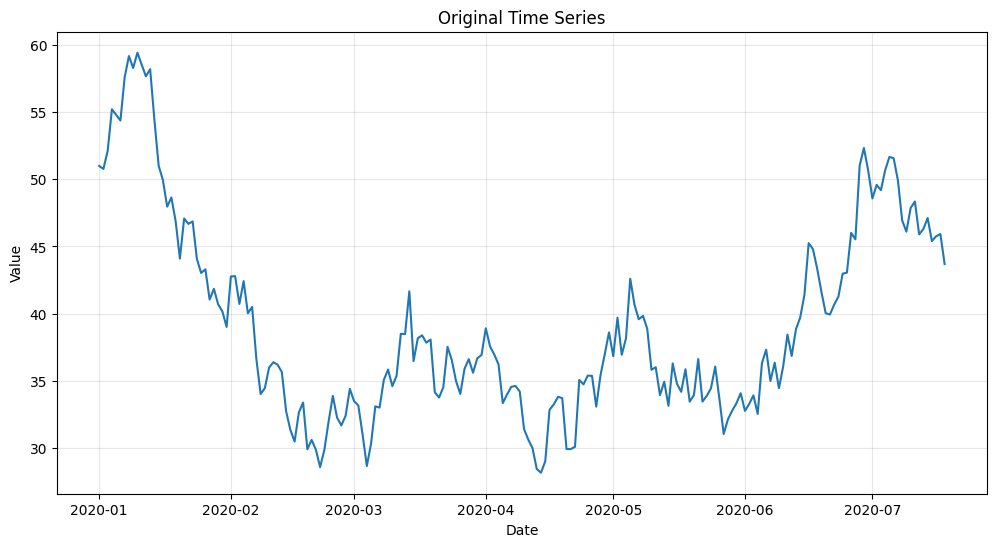


--- Applying First Differencing ---


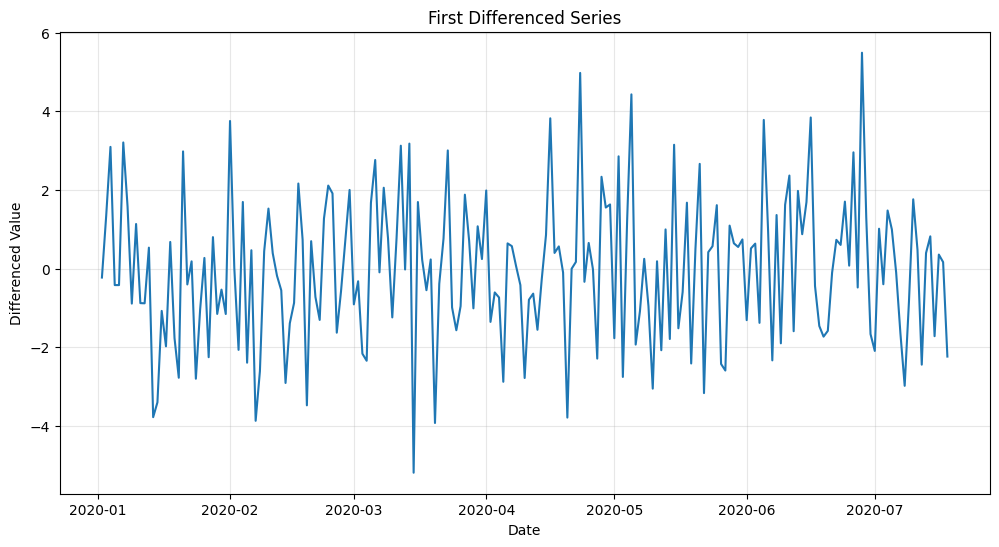

Augmented Dickey-Fuller Test Results for First Differenced Series:
ADF Test Statistic: -14.6918
p-value: 0.0000
# Lags Used: 0
# Observations: 198
Critical Values:
   1%: -3.4638
   5%: -2.8763
   10%: -2.5746

Conclusion: The First Differenced Series is STATIONARY (p-value ≤ 0.05)

--- Stationarity Analysis Summary ---
The series became stationary after first differencing.
Recommended ARIMA order: d=1


In [9]:
# Function to conduct ADF test
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    
    print(f'Augmented Dickey-Fuller Test Results for {title}:')
    print(f'ADF Test Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'# Lags Used: {result[2]}')
    print(f'# Observations: {result[3]}')
    
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    is_stationary = result[1] <= 0.05
    
    if is_stationary:
        print(f'\nConclusion: The {title} is STATIONARY (p-value ≤ 0.05)')
    else:
        print(f'\nConclusion: The {title} is NON-STATIONARY (p-value > 0.05)')
        
    return is_stationary

# Test original series for stationarity
print("\n--- Testing Original Series ---")
is_stationary = adf_test(df['Value'], 'Original Series')

# Plot original series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Value'])
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

# If not stationary, apply differencing
if not is_stationary:
    print("\n--- Applying First Differencing ---")
    df['First_Difference'] = df['Value'].diff()
    
    # Plot differenced series
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[1:], df['First_Difference'][1:])  # Skip first NaN value
    plt.title('First Differenced Series')
    plt.xlabel('Date')
    plt.ylabel('Differenced Value')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Test differenced series for stationarity
    first_diff_stationary = adf_test(df['First_Difference'].dropna(), 'First Differenced Series')
    
    # If still not stationary, apply second differencing
    if not first_diff_stationary:
        print("\n--- Applying Second Differencing ---")
        df['Second_Difference'] = df['First_Difference'].diff()
        
        # Plot second differenced series
        plt.figure(figsize=(12, 6))
        plt.plot(df.index[2:], df['Second_Difference'][2:])  # Skip first two NaN values
        plt.title('Second Differenced Series')
        plt.xlabel('Date')
        plt.ylabel('Second Differenced Value')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Test second differenced series for stationarity
        adf_test(df['Second_Difference'].dropna(), 'Second Differenced Series')

# Summary
print("\n--- Stationarity Analysis Summary ---")
if is_stationary:
    print("The original time series is stationary. No differencing needed.")
    print("Recommended ARIMA order: d=0")
else:
    if 'First_Difference' in df.columns:
        if first_diff_stationary:
            print("The series became stationary after first differencing.")
            print("Recommended ARIMA order: d=1")
        elif 'Second_Difference' in df.columns:
            print("The series became stationary after second differencing.")
            print("Recommended ARIMA order: d=2")
        else:
            print("The series might need higher-order differencing to become stationary.")
            print("Consider other transformations or models.")

### ARIMA MODEL 
### AutoRegressive Integrated Moving Average: 

p = AutoRegressive (AR) = Number of lag observations 

d = Integrated (I) = differenced to make the series stationary. 

q = Moving Average (MA) = lagged forecast errors

In [12]:
# Select only the univariate series
series = df['Value']

# Fit ARIMA model
model = ARIMA(series[:-20], order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  180
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -368.297
Date:                Tue, 20 May 2025   AIC                            742.594
Time:                        11:26:17   BIC                            752.156
Sample:                    01-01-2020   HQIC                           746.471
                         - 06-28-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2710      1.025      0.264      0.792      -1.739       2.281
ma.L1         -0.3420      0.994     -0.344      0.731      -2.290       1.606
sigma2         3.5863      0.382      9.396      0.0

/Users/dianaterraza/Desktop/mini_project/myvenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dianaterraza/Desktop/mini_project/myvenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dianaterraza/Desktop/mini_project/myvenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are model selection metrics commonly used when fitting ARIMA models (and other statistical models).

Both AIC and BIC help you compare different ARIMA models to decide which one fits the data best without overfitting.

* They balance model fit (likelihood) vs. complexity (number of parameters).

* Lower values are better → they indicate a better model.



### Plot Actual vs Fitted Model

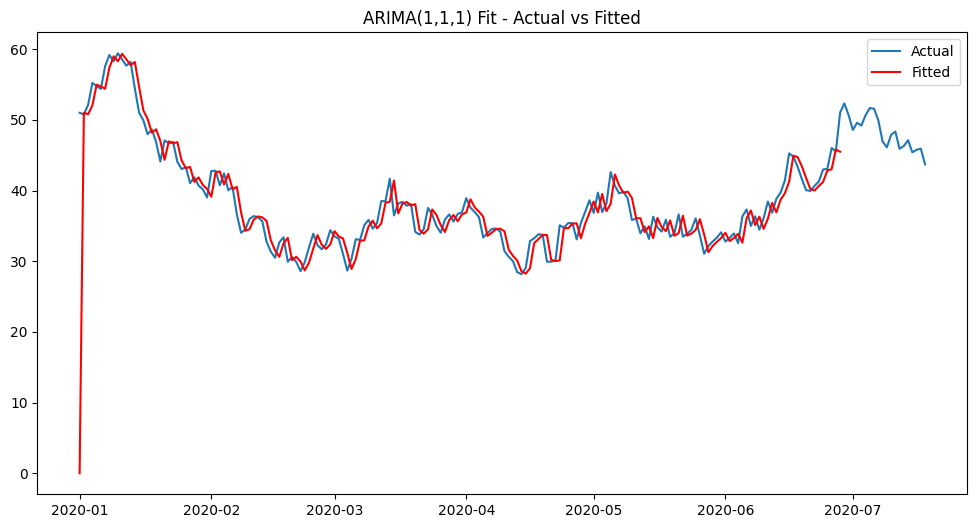

In [13]:
import matplotlib.pyplot as plt

# Plot actual values
plt.figure(figsize=(12, 6))
plt.plot(df['Value'], label='Actual')

# Plot fitted values (aligned to original index)
plt.plot(model_fit.fittedvalues, label='Fitted', color='red')

plt.title('ARIMA(1,1,1) Fit - Actual vs Fitted')
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Use only the training portion of the true series
y_true = df['Value'][:-20]  # same length as y_pred

# Predicted values from the model
y_pred = model_fit.fittedvalues

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape:.2f}%')
print(f'AIC: {model_fit.aic}')
print(f'BIC: {model_fit.bic}')



MAE: 1.7716632437016206
MSE: 18.012722758638457
RMSE: 4.2441398137477115
MAPE: 4.54%
AIC: 742.5937433838337
BIC: 752.155900801356


### Forecast and Plot Future Values

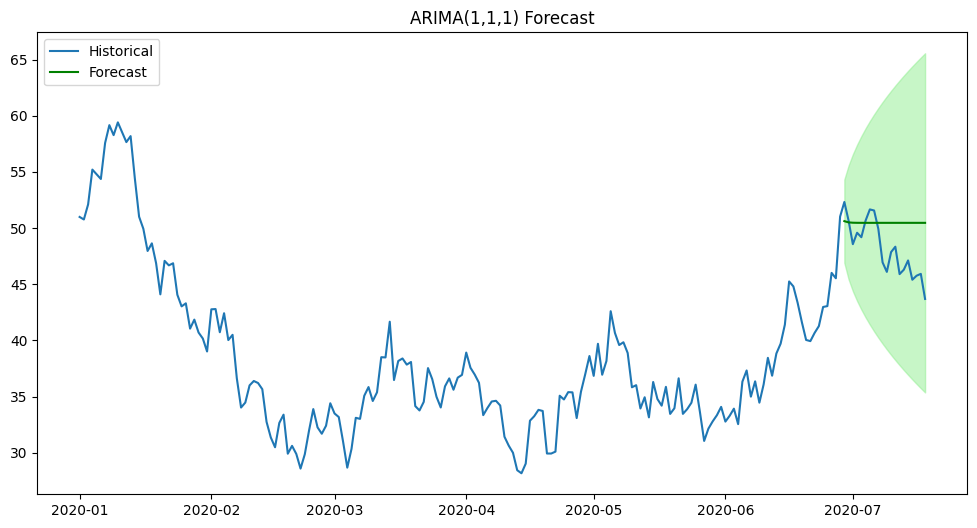

In [16]:
# Forecast next 20 steps
forecast_steps = 20
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot historical data
plt.figure(figsize=(12, 6))
plt.plot(df['Value'], label='Historical')

# Plot forecast
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')

# Plot confidence intervals
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='lightgreen', alpha=0.5)

plt.title('ARIMA(1,1,1) Forecast')
plt.legend()
plt.show()


In [17]:
df['Value']


Date
2020-01-01    50.993428
2020-01-02    50.767151
2020-01-03    52.112779
2020-01-04    55.209090
2020-01-05    54.791035
                ...    
2020-07-14    47.120397
2020-07-15    45.402933
2020-07-16    45.760635
2020-07-17    45.927303
2020-07-18    43.691614
Name: Value, Length: 200, dtype: float64

### Plot Residuals

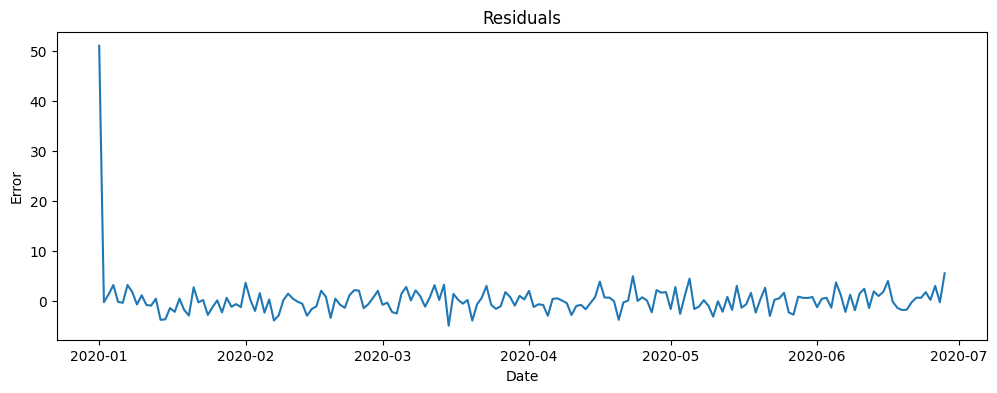

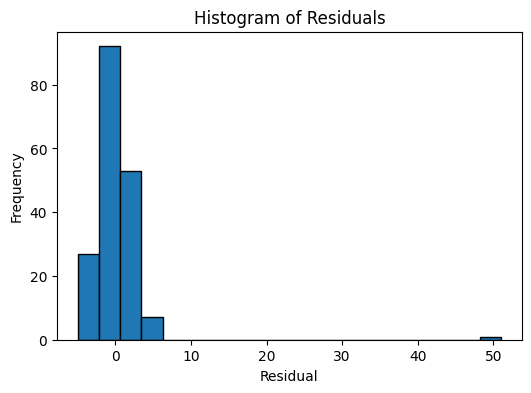

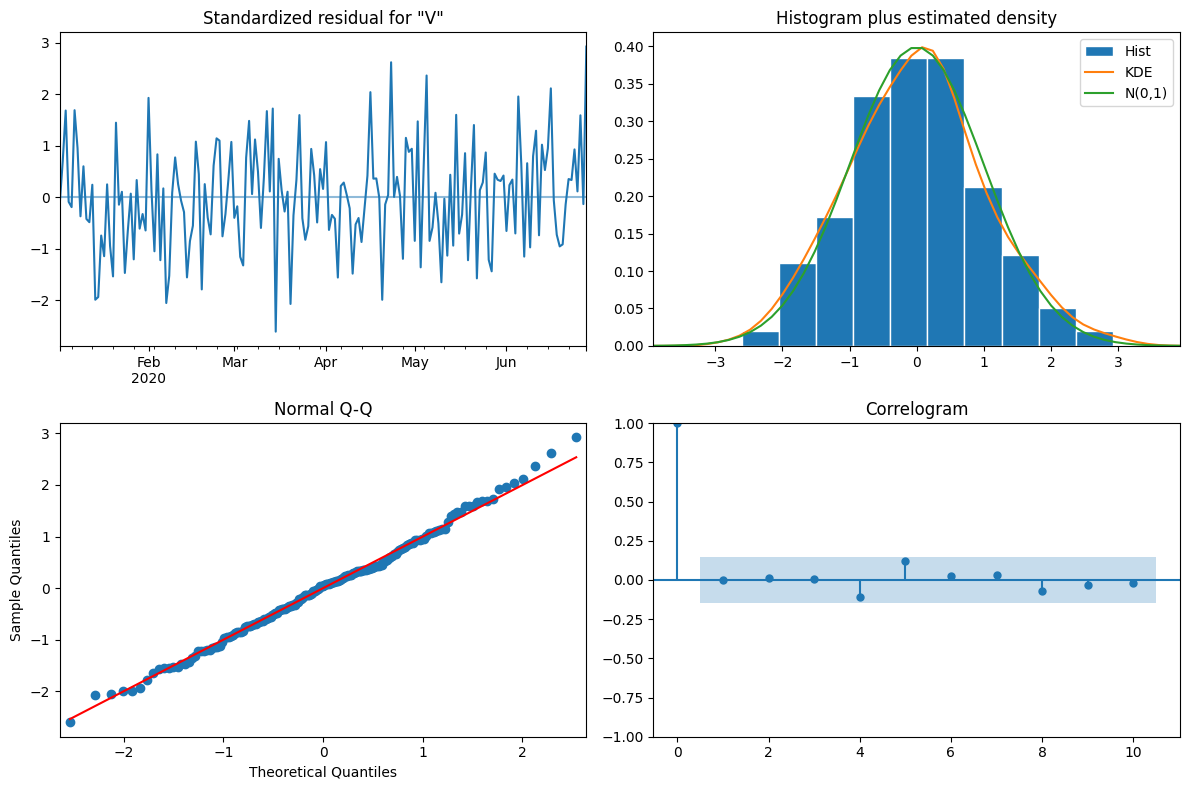

In [18]:
# Step 3: Residual Diagnostics
residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Error')
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Full diagnostics (also includes ACF, QQ, etc.)
model_fit.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

✅ ACF (Autocorrelation Function)

* What it is: Measures how current values of the series are related to its past values (lags).

* Interpretation: A high autocorrelation at lag k means the value k time steps ago has a strong influence on the current value.

* Used for: Choosing the q parameter in an ARIMA model (i.e., moving average terms).

Example:
If ACF shows a significant drop after lag 1, it suggests a MA(1) model may be a good fit.

✅ PACF (Partial Autocorrelation Function)

* What it is: Measures the correlation between the series and its lags after removing the influence of intermediate lags.

* Interpretation: Shows the "direct" relationship between observations that are k lags apart.

* Used for: Choosing the p parameter in an ARIMA model (i.e., autoregressive terms).

Example:
If PACF cuts off after lag 2, it suggests an AR(2) model may be appropriate.

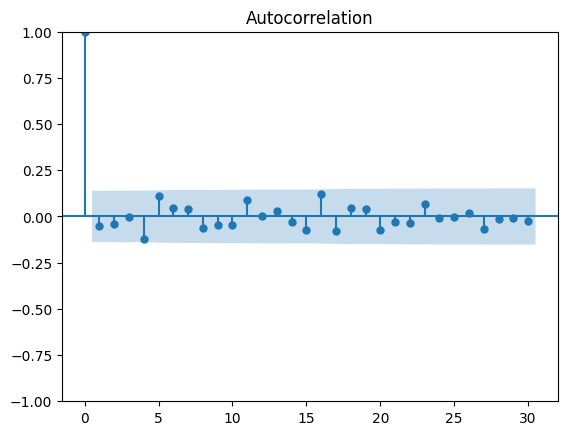

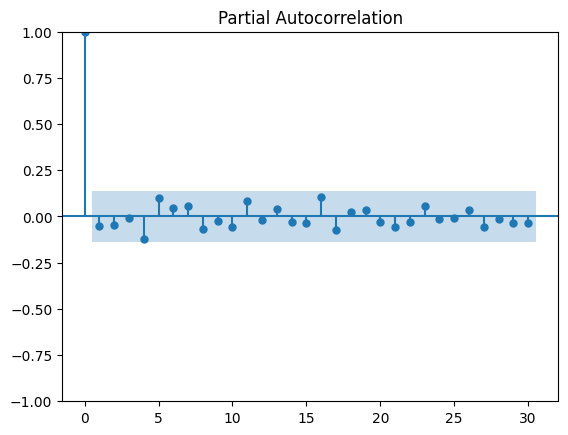

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_diff, lags=30)
plt.show()

plot_pacf(df_diff, lags=30)
plt.show()


For the Machine Learning model build on Task 1: 1. Evaluate the Model - Assess the model’s accuracy and effectiveness. - Test the model on the validation/test dataset. - Select appropriate metric/s considering the business case: - Regression models: R², MAE, RMSE. - Check for overfitting by comparing training vs. test performance and using cross-validation. - Interpret the model’s predictions and assess their real-world applicability.